<h1 style="font-size:3em; text-align: center">LSTM The Hard Way</h1>


In [166]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from scipy.stats  import norm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

Loss Function that Penalizes Over-Estimates Inspired from <br/>
https://datascience.stackexchange.com/questions/10471/linear-regression-with-non-symmetric-cost-function

# Adjusting the Loss Function

These next couple cells have to do with adjusting the loss function and the network to allow for no more than 10% of predictions to be overestimations while still preserving accuracy

In [144]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [145]:
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [146]:
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )


In [147]:
def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        total = 0
        num_overestimating = 0
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            for j in range(len(indiv_err)):
                total += 1.0
                if (predictions[j, i] > true_vals[j, i]):
                    num_overestimating += 1.0
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print num_overestimating / total * 100

Epoch 1/5
6s - loss: 0.0047
Epoch 2/5
6s - loss: 0.0028
Epoch 3/5
6s - loss: 0.0024
Epoch 4/5
6s - loss: 0.0023
Epoch 5/5
6s - loss: 0.0021


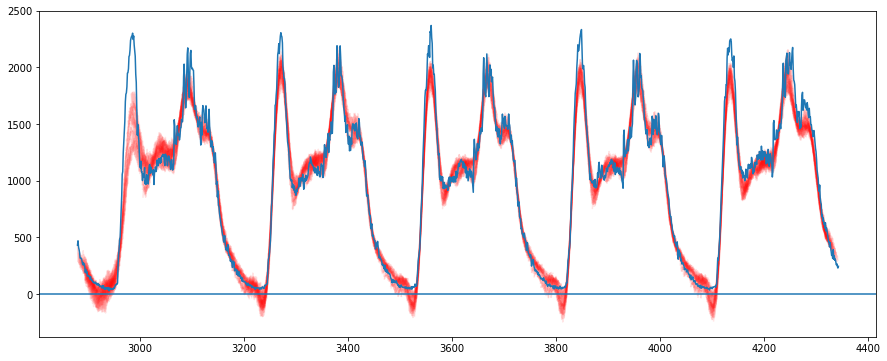

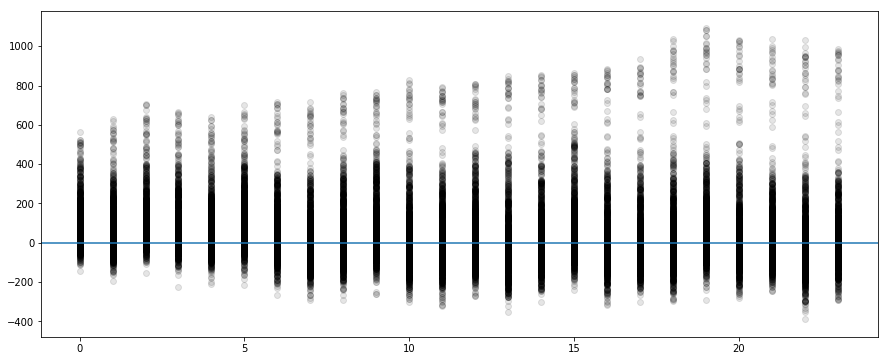

42.7864583333


In [3]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 1
seed = 11

np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
predict(total_days=5,day=10,delta=1)

# Calculating Uncertainty Using Dropout

These next couple cells are done after experimenting with the loss function. Here, I add dropout to each layer, and increase the number of neurons in each layer to make up for the drop out rate as suggested in the articles. The prediction process has been adjusted to calcuate every 2 hours instead of every 5 minutes and 100 times each. The average of the predictions is shown as a difinitve line and then surrounded by a standard deviation of uncertainty.

In [149]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)


In [150]:
 def predict_with_uncertainty(f, dataset, n_iter=100):
    result = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        result[iter] = f([dataset, 1])
    prediction = result.mean(axis=0)
    uncertainty = np.std(result, axis=0)
    return result, prediction, uncertainty

In [151]:
# If f is defined, this returns an array
def predictNext2Hours (model, dataset, f=None):
    
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    
    if f is None:
        # make a prediction
        prediction = model.predict(data)
        prediction = scaler.inverse_transform(prediction)
        return prediction
    else:
        results, prediction, uncertainty = predict_with_uncertainty(f, data)
        
        # The Average Prediction
        prediction = scaler.inverse_transform(prediction)
        # The Standard Deviation At Each T Of Prediction
        uncertainty = scaler.inverse_transform(uncertainty)
        
        return prediction, uncertainty, results
 

In [156]:
def predict (f=None, day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals   = np.array([])
    percent_over = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        if f is None:
            prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        else:
            prediction, uncertainty, results = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back), f=f)
            
            true_values = dataset_orig[point:point+look_forward].reshape(24)
            # All the Predictions
            results = results.reshape(results.shape[0], look_forward)
            results = scaler.inverse_transform(results)
            true_values = np.ones( len(results) ).reshape(len(results), 1)*true_values
            error = true_values - results
            temp_percent_over = 100.0 * (error < 0).sum() / error.size
            
            percent_over = np.append(percent_over, temp_percent_over)
            prediction = prediction.reshape(look_forward)
            uncertainty = uncertainty.reshape(look_forward)
            # plots the uncertainty to the degree of half a standard deviation
            plt.fill_between(range(point, point+look_forward), prediction + uncertainty/2.0, prediction - uncertainty/2.0, facecolor='red', alpha=0.25)
            # plots the uncertainty to the degree of a full standard deviation
            plt.fill_between(range(point, point+look_forward), prediction+uncertainty, prediction-uncertainty, facecolor='red', alpha=0.25)
        # plots the predictions
        plt.plot(range(point, point+look_forward), prediction, color='red', alpha=1)
        
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print "Percent Overestimating:"
        print np.mean(percent_over)

In [153]:
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.6)

In [ ]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*14
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (20):
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])
    
predict(f=func, total_days=1,day=11,delta=24)


Epoch 1/5
18s - loss: 0.0083
Epoch 2/5
16s - loss: 0.0053
Epoch 3/5
16s - loss: 0.0046
Epoch 4/5
16s - loss: 0.0043
Epoch 5/5
16s - loss: 0.0040
Epoch 1/1


## Uncertainty Without the Over_Penalty Loss Function

In [286]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')

dataframe['weekend'] = dataframe.index
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (20):
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])
    
predict(f=func, total_days=1,day=11,delta=24)


Epoch 1/5


KeyboardInterrupt: 

# Calculating Uncertainty And Mapping to A Gausian Distribution


In [149]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)


In [150]:
 def predict_with_uncertainty(f, dataset, n_iter=100):
    result = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        result[iter] = f([dataset, 1])
    prediction = result.mean(axis=0)
    uncertainty = np.std(result, axis=0)
    return result, prediction, uncertainty

In [151]:
# If f is defined, this returns an array
def predictNext2Hours (model, dataset, f=None):
    
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    
    if f is None:
        # make a prediction
        prediction = model.predict(data)
        prediction = scaler.inverse_transform(prediction)
        return prediction
    else:
        results, prediction, uncertainty = predict_with_uncertainty(f, data)
        
        # The Average Prediction
        prediction = scaler.inverse_transform(prediction)
        # The Standard Deviation At Each T Of Prediction
        standard_deviation = scaler.inverse_transform(uncertainty)
        
        return prediction, standard_deviation, results
 

In [249]:
def predict (f=None, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    predictions = np.array([])
    true_vals   = np.array([])
    percent_over = np.array([])
    
    cdf_vals = np.zeros((total_days*288/delta, 24))
    
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        if f is None:
            prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        else:
            prediction, standard_deviation, results = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back), f=f)
            
            # Gets the true original values
            true_values = dataset_orig[point:point+look_forward].reshape(24)
            
            # Reshapes the mean_predictions and the standard deviations into a vector of size look_forward
            prediction = prediction.reshape(look_forward)
            standard_deviation = standard_deviation.reshape(look_forward)
            
            # converts the original values to cdf values according to the distibutions at t+1, t+2, ..., t+24 (0.0-1.0)
            step_cdf_vals = norm.cdf(true_values, loc=prediction, scale=standard_deviation)
            # Adds the above values to the overall matrix of cdf
            cdf_vals[i,:] = step_cdf_vals
            
            # calculates the percent of the predictions that are overestimating
            results = results.reshape(results.shape[0], look_forward)
            results = scaler.inverse_transform(results)
            true_values = np.ones( len(results) ).reshape(len(results), 1)*true_values
            error = true_values - results
            temp_percent_over = 100.0 * (error < 0).sum() / error.size
            percent_over = np.append(percent_over, temp_percent_over)
            
            
            if(show_graph):
                # plots the uncertainty to the degree of half a standard deviation
                plt.fill_between(range(point, point+look_forward), prediction + standard_deviation/2.0, prediction - standard_deviation/2.0, facecolor='red', alpha=0.25)
                # plots the uncertainty to the degree of a full standard deviation
                plt.fill_between(range(point, point+look_forward), prediction+standard_deviation, prediction-standard_deviation, facecolor='red', alpha=0.25)
        
        
        if(show_graph):
            # plots the predictions
            plt.plot(range(point, point+look_forward), prediction, color='red', alpha=1)
        
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    if(show_graph):
        plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
        plt.axhline(0)
        plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    print "Percent Overestimating:"
    print np.mean(percent_over)
    return cdf_vals

In [259]:
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.6)

def under_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) + 0.4)

Epoch 1/5
10s - loss: 0.0136
Epoch 2/5
4s - loss: 0.0075
Epoch 3/5
4s - loss: 0.0064
Epoch 4/5
4s - loss: 0.0059
Epoch 5/5
4s - loss: 0.0055
0
Epoch 1/1
4s - loss: 0.0051
Epoch 1/1
4s - loss: 0.0049
Epoch 1/1
4s - loss: 0.0047
Epoch 1/1
4s - loss: 0.0046
Epoch 1/1
4s - loss: 0.0045
Epoch 1/1
4s - loss: 0.0042
Epoch 1/1
4s - loss: 0.0041
Epoch 1/1
4s - loss: 0.0040
Epoch 1/1
4s - loss: 0.0040
Epoch 1/1
4s - loss: 0.0039


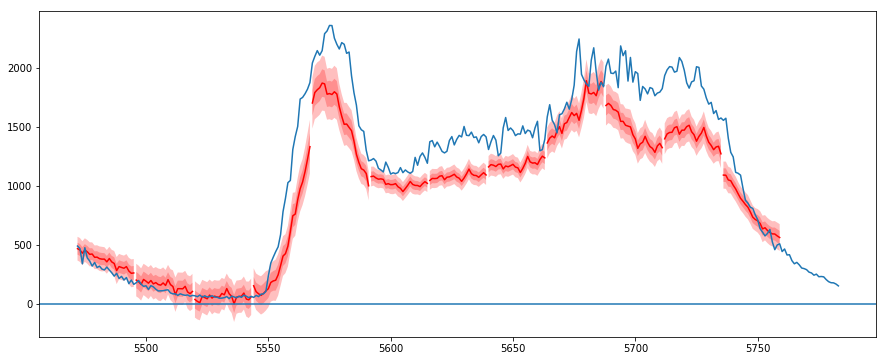

Percent Overestimating:
22.1319444444
Epoch 1/5
10s - loss: 0.0133
Epoch 2/5
3s - loss: 0.0069
Epoch 3/5
4s - loss: 0.0060
Epoch 4/5
4s - loss: 0.0054
Epoch 5/5
4s - loss: 0.0051
0
Epoch 1/1
4s - loss: 0.0048
Epoch 1/1
4s - loss: 0.0045
Epoch 1/1
4s - loss: 0.0044
Epoch 1/1
4s - loss: 0.0042
Epoch 1/1
4s - loss: 0.0042
Epoch 1/1
4s - loss: 0.0040
Epoch 1/1
4s - loss: 0.0039
Epoch 1/1
4s - loss: 0.0039
Epoch 1/1
4s - loss: 0.0038
Epoch 1/1
4s - loss: 0.0037


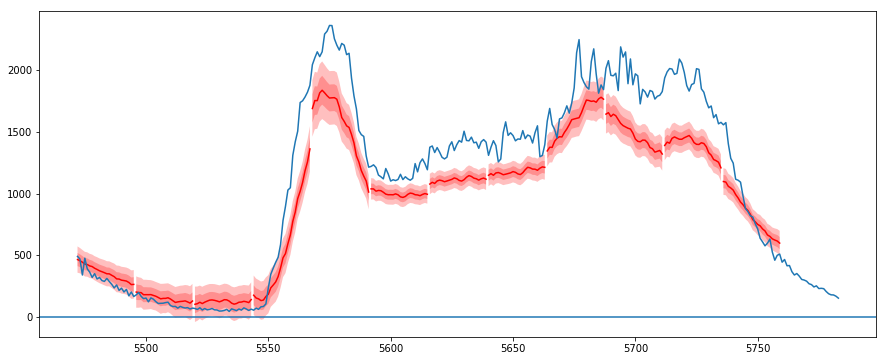

Percent Overestimating:
25.4652777778


array([[ 0.59488785,  0.5513997 ,  0.14859429,  0.68581723,  0.36124815,
         0.30277743,  0.18218896,  0.32733523,  0.2200618 ,  0.29472532,
         0.23964615,  0.24506116,  0.35447302,  0.26929007,  0.23911726,
         0.19471173,  0.32430101,  0.19779683,  0.27557931,  0.19719099,
         0.26783859,  0.16775079,  0.30171818,  0.19769953],
       [ 0.42966059,  0.50104192,  0.40128059,  0.39688973,  0.41068298,
         0.31307666,  0.40944397,  0.39884018,  0.3532105 ,  0.34108323,
         0.38223954,  0.37133222,  0.387978  ,  0.37929944,  0.32699232,
         0.350396  ,  0.39874565,  0.34387355,  0.37810509,  0.34940569,
         0.32721952,  0.36508142,  0.36343963,  0.33903166],
       [ 0.40606939,  0.36740699,  0.37049517,  0.3523012 ,  0.35195754,
         0.29708462,  0.28412377,  0.2953121 ,  0.27875774,  0.29107983,
         0.28737245,  0.2700922 ,  0.25053981,  0.27511191,  0.26086645,
         0.36603916,  0.3707497 ,  0.33636146,  0.33983923,  0.31264292,
  

In [266]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*18
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 6
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
#model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (10):
    if(i % 10 == 0):
        print i
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])

predict(f=func, total_days=1,day=19,delta=24)


b = 6
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
#model.compile(loss=under_penalty, optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (10):
    if(i % 10 == 0):
        print i
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])

predict(f=func, total_days=1,day=19,delta=24)


In [254]:
cdf_matrix = predict(f=func, total_days=4,day=15,delta=1, show_graph=False)

Percent Overestimating:
33.8118127894


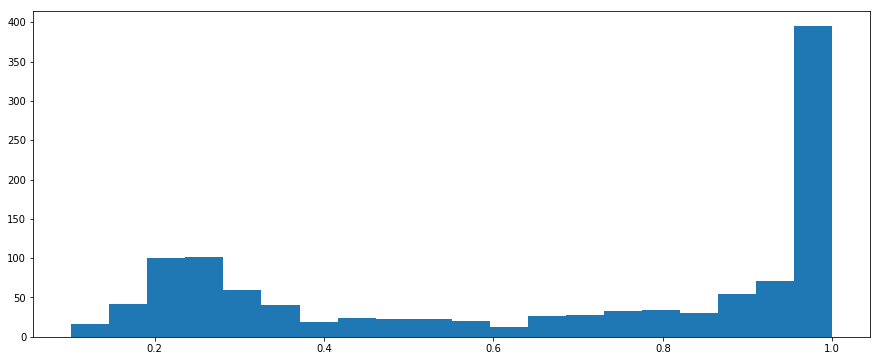

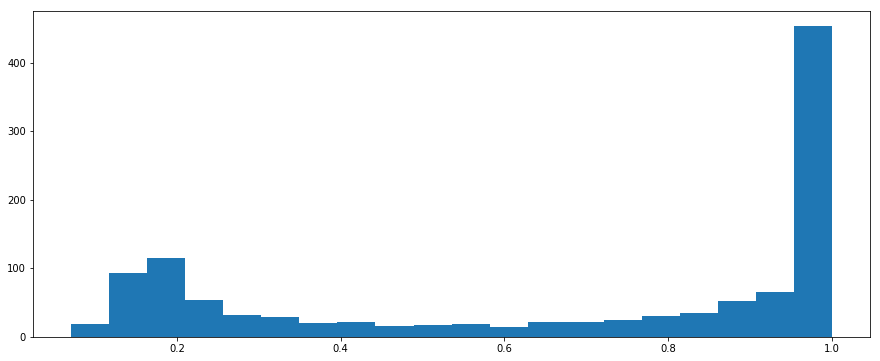

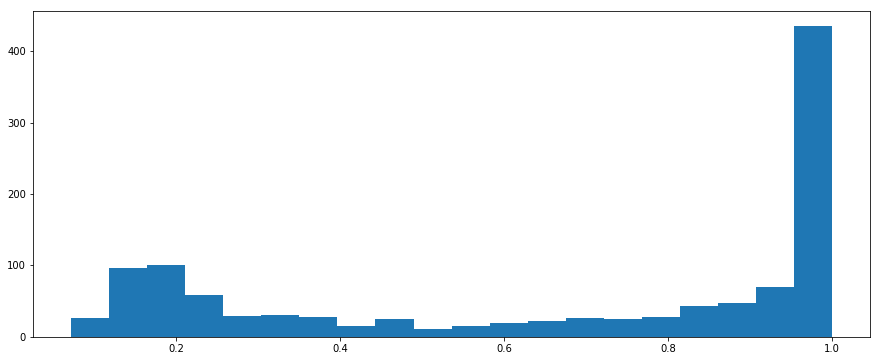

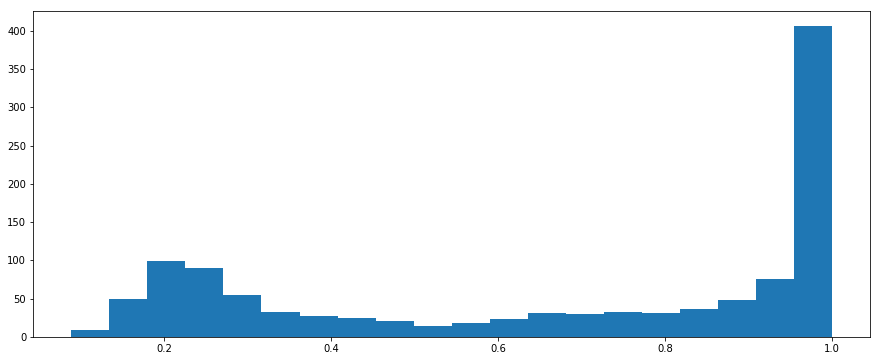

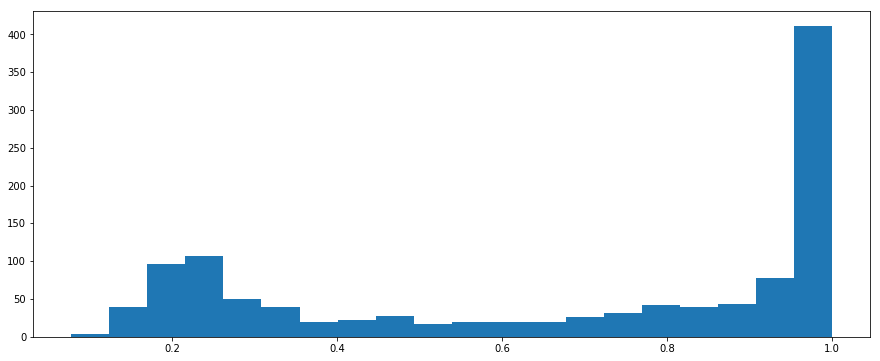

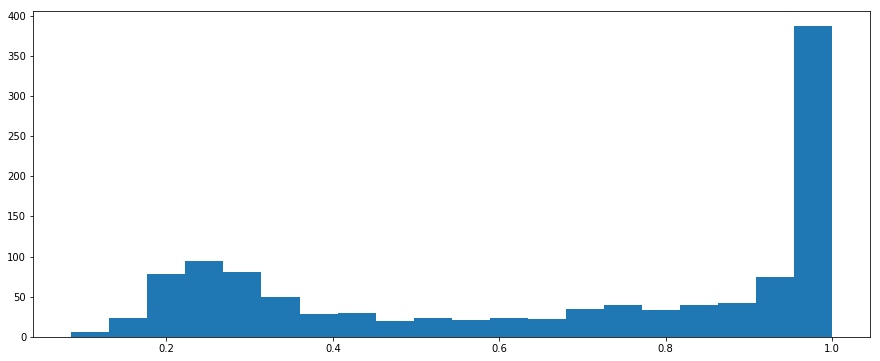

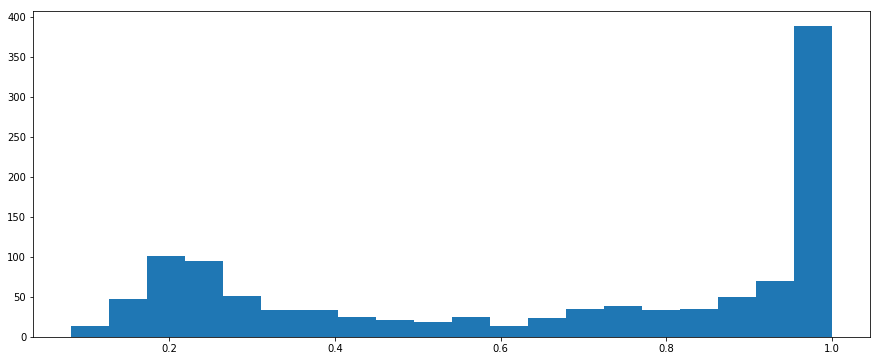

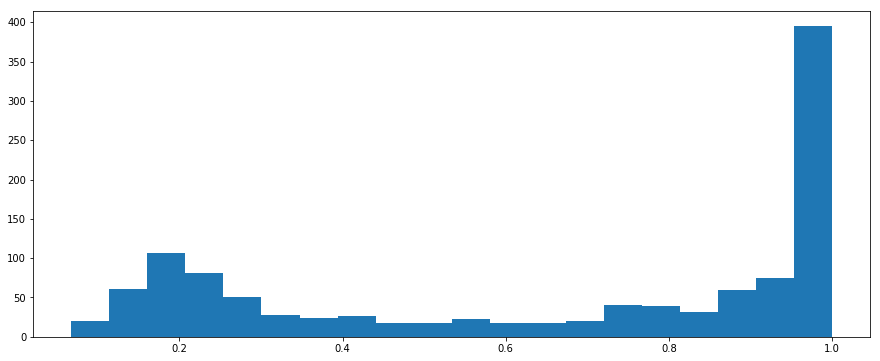

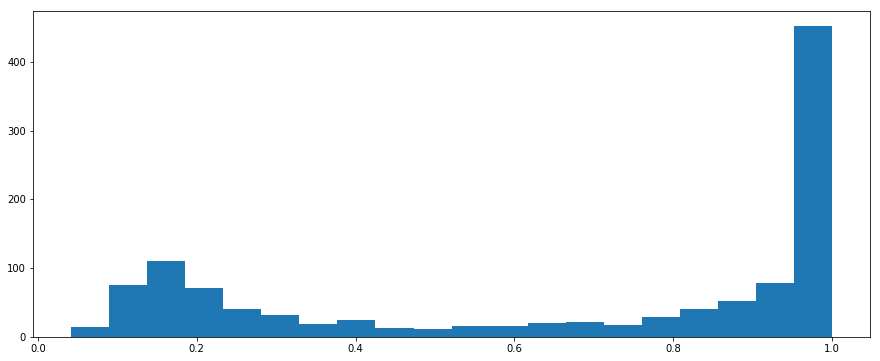

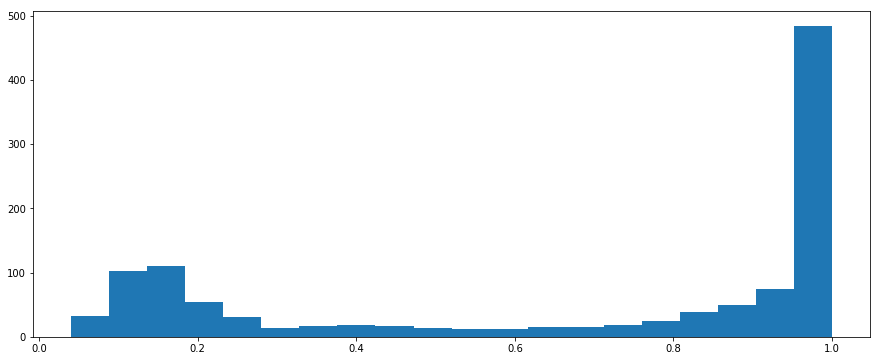

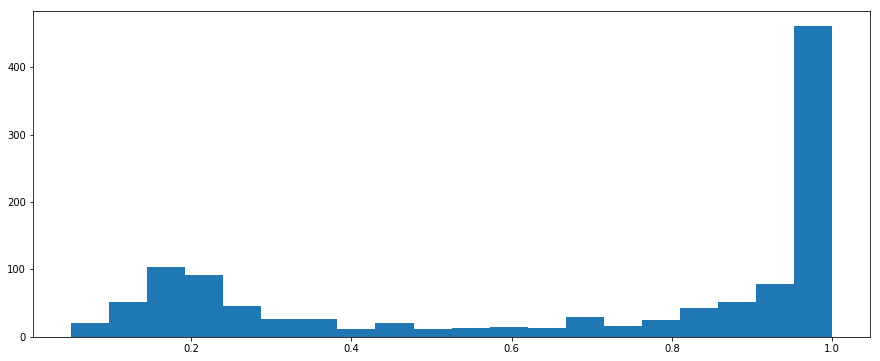

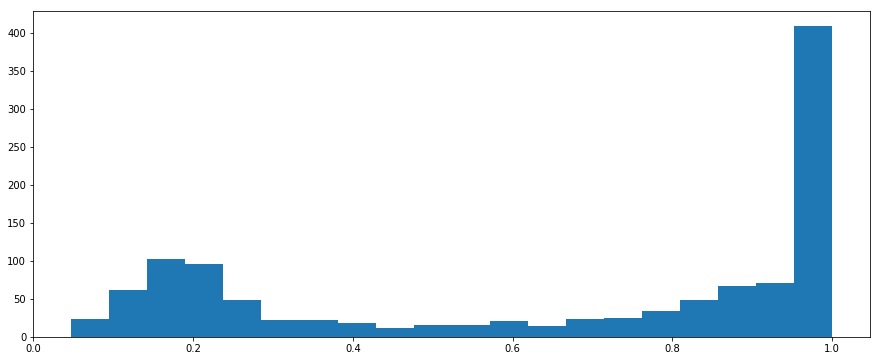

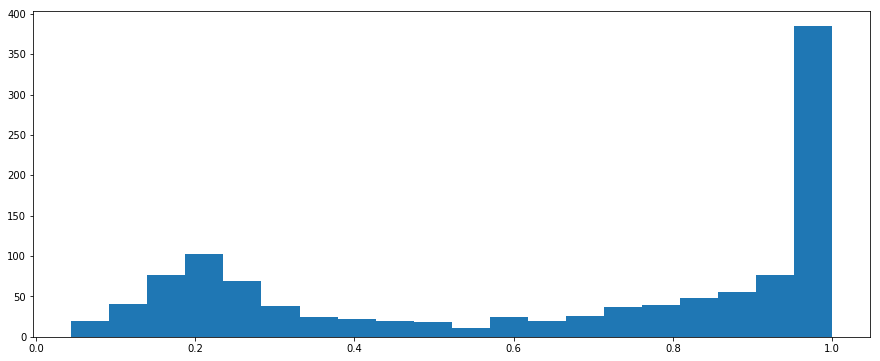

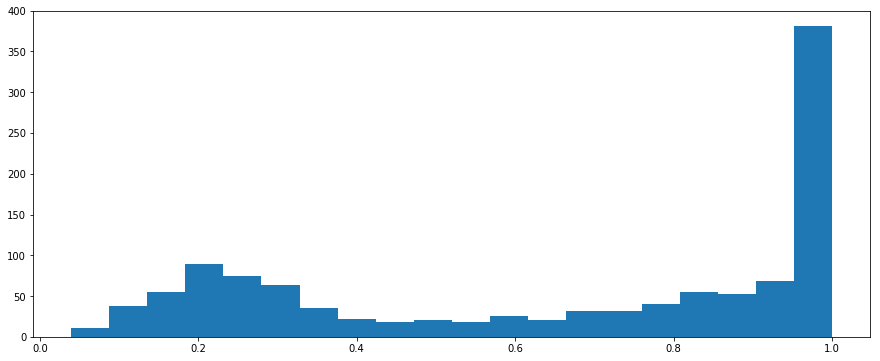

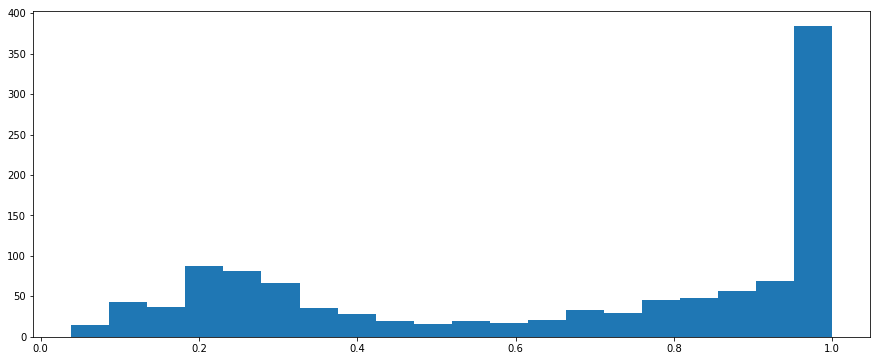

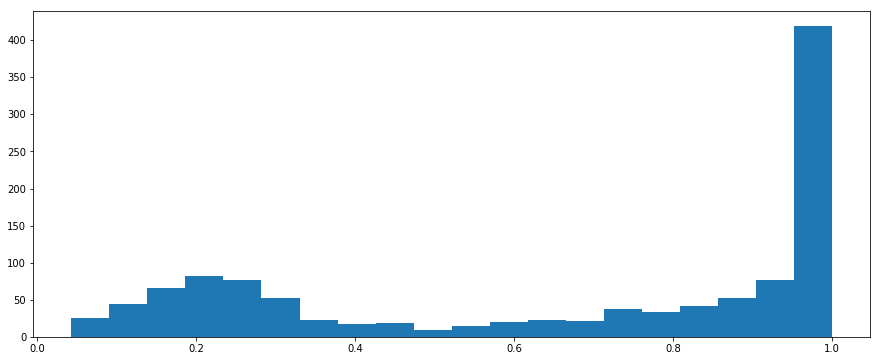

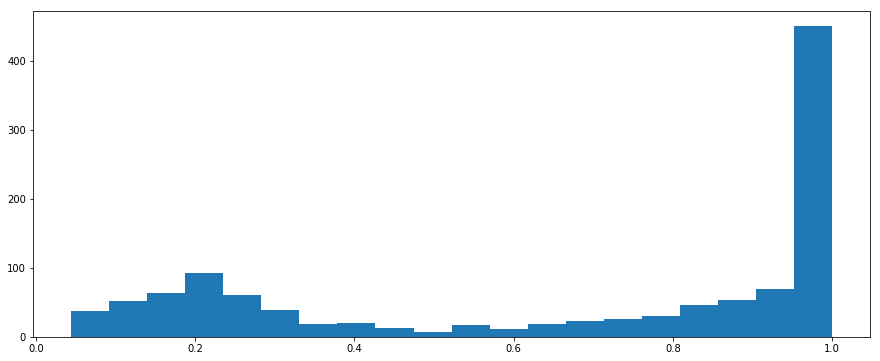

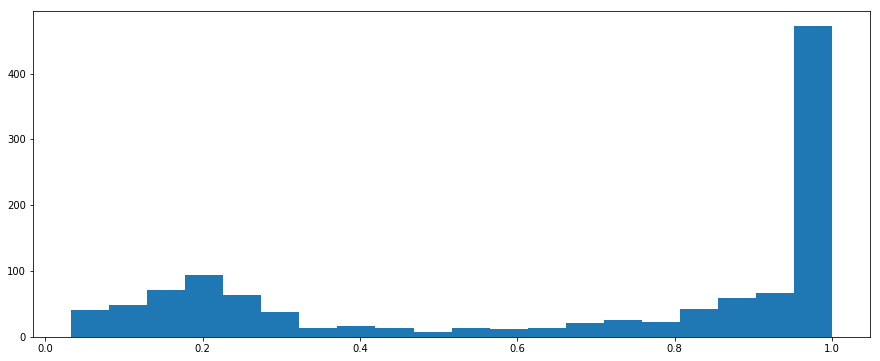

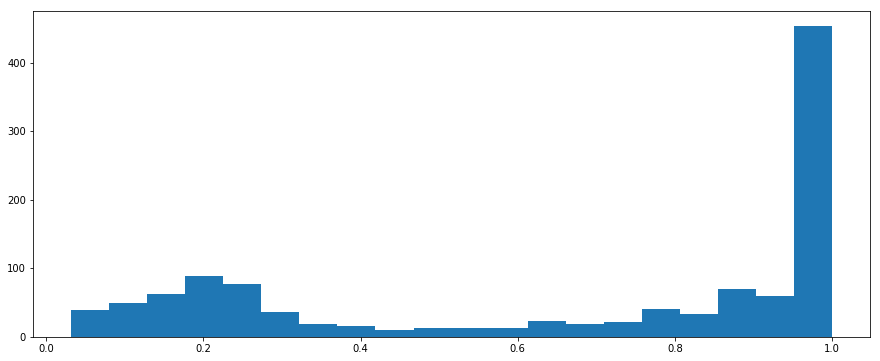

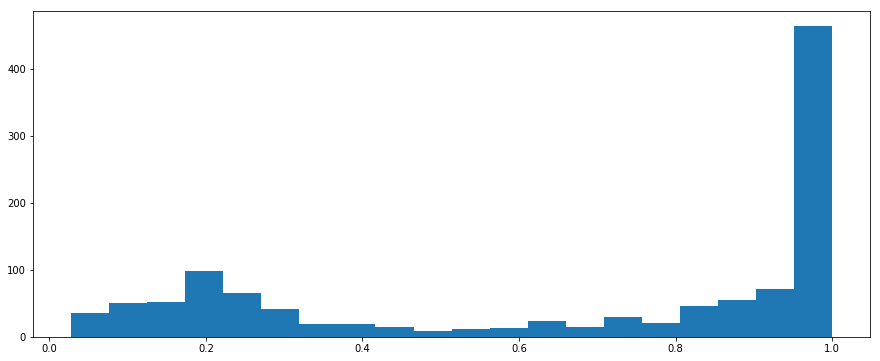

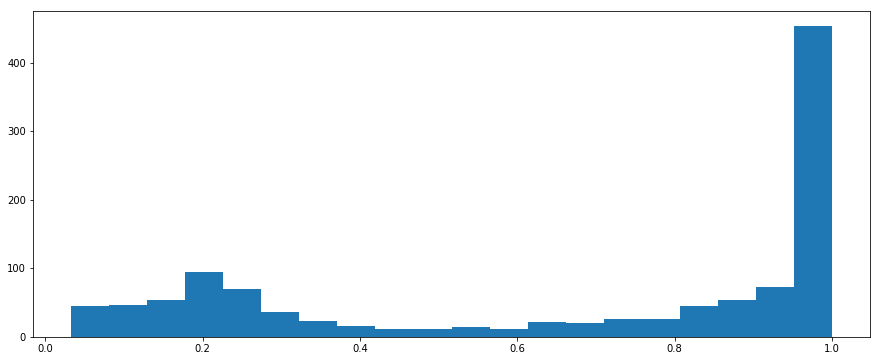

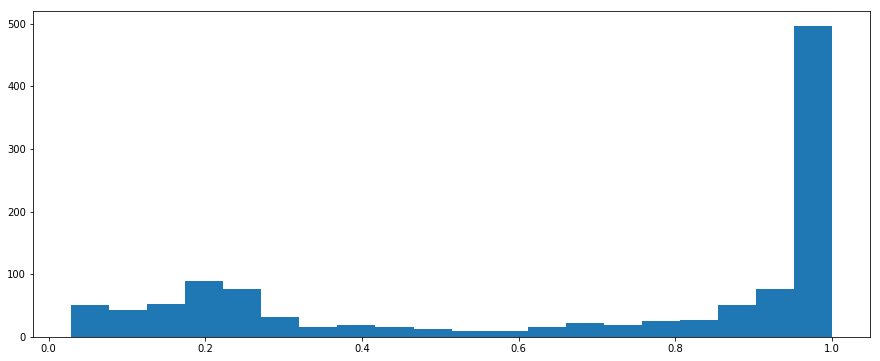

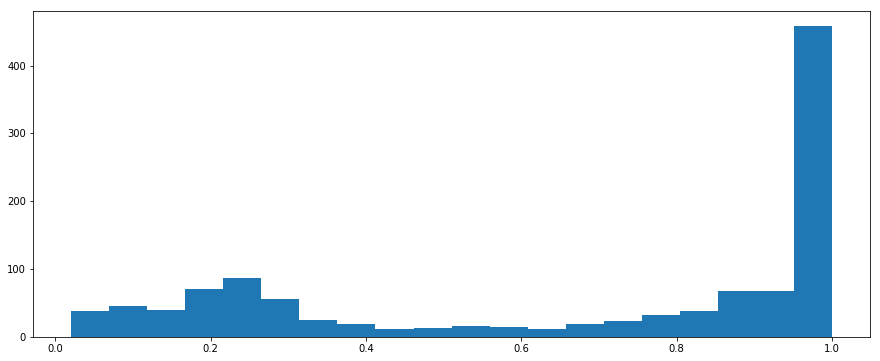

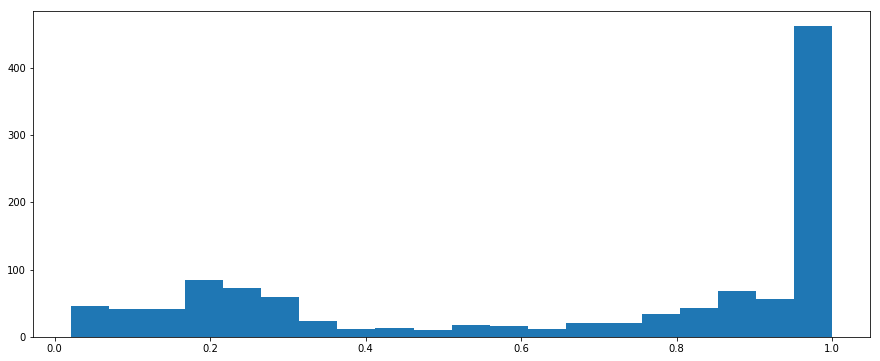

In [264]:

for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()

Epoch 1/5
19s - loss: 0.0135
Epoch 2/5
16s - loss: 0.0077
Epoch 3/5
16s - loss: 0.0067
Epoch 4/5
16s - loss: 0.0061
Epoch 5/5
16s - loss: 0.0058
Epoch 1/1
16s - loss: 0.0053
Epoch 1/1
16s - loss: 0.0052
Epoch 1/1
16s - loss: 0.0051
Epoch 1/1
16s - loss: 0.0050
Epoch 1/1
16s - loss: 0.0049
Epoch 1/1
16s - loss: 0.0047
Epoch 1/1
16s - loss: 0.0048
Epoch 1/1
16s - loss: 0.0047
Epoch 1/1
16s - loss: 0.0046
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0044
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0043
Epoch 1/1
16s - loss: 0.0044
Epoch 1/1
16s - loss: 0.0045
Epoch 1/1
16s - loss: 0.0042
Epoch 1/1
16s - loss: 0.0043


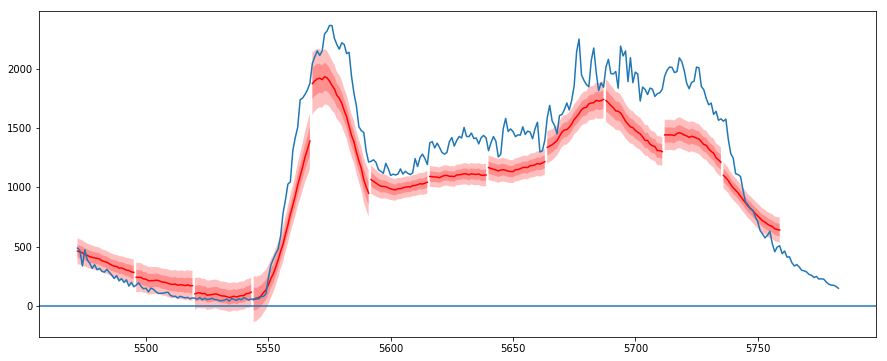

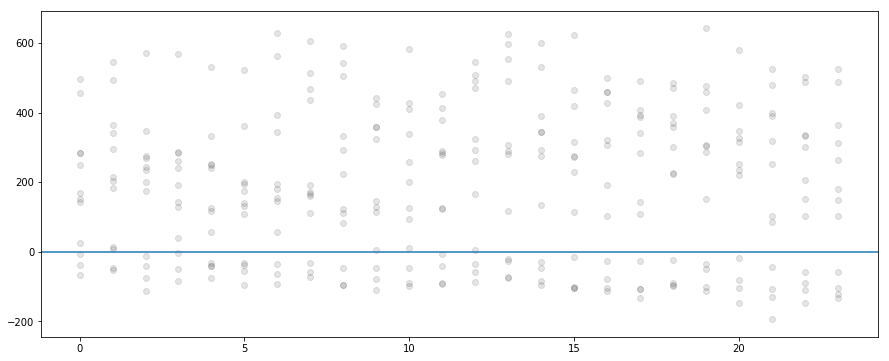

Percent Overestimating:
26.5659722222
cdf Matrix
[[ 0.59331894  0.54742022  0.14006575  0.64975605  0.34716408  0.29173177
   0.17468897  0.2829062   0.16007724  0.20692694  0.17356208  0.17565311
   0.2697931   0.22924776  0.19645681  0.14510621  0.21642381  0.14302547
   0.1843549   0.13077753  0.21366327  0.10372235  0.20588486  0.13437943]
 [ 0.29963303  0.3540465   0.26253684  0.23922334  0.25515676  0.20885298
   0.29304606  0.2624214   0.1966178   0.16383943  0.18759093  0.20747183
   0.22736389  0.25801513  0.20924218  0.19298866  0.19030419  0.18614199
   0.20810196  0.19862517  0.20128278  0.19713987  0.19164251  0.20958673]
 [ 0.39051519  0.34314417  0.37738248  0.34418179  0.37005937  0.38343974
   0.3879791   0.40052229  0.34942557  0.3486656   0.34788991  0.36967194
   0.3872555   0.43114814  0.40198666  0.45401539  0.40941215  0.4098396
   0.42652591  0.38337883  0.43972753  0.36078012  0.31949364  0.32371517]
 [ 0.48542004  0.52047472  0.47090163  0.48974223  0.42809544

In [178]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*14
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (20):
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])
    
predict(f=func, total_days=1,day=19,delta=24)


Epoch 1/5
19s - loss: 0.0871
Epoch 2/5
16s - loss: 0.0680
Epoch 3/5
16s - loss: 0.0639
Epoch 4/5
16s - loss: 0.0601
Epoch 5/5
16s - loss: 0.0577
Epoch 1/1
16s - loss: 0.0558
Epoch 1/1
16s - loss: 0.0549
Epoch 1/1
16s - loss: 0.0537
Epoch 1/1
16s - loss: 0.0529
Epoch 1/1
16s - loss: 0.0515
Epoch 1/1
16s - loss: 0.0509
Epoch 1/1
16s - loss: 0.0510
Epoch 1/1
16s - loss: 0.0506
Epoch 1/1
16s - loss: 0.0499
Epoch 1/1
16s - loss: 0.0497
Epoch 1/1
16s - loss: 0.0483
Epoch 1/1
16s - loss: 0.0485
Epoch 1/1
16s - loss: 0.0484
Epoch 1/1
16s - loss: 0.0489
Epoch 1/1
16s - loss: 0.0480
Epoch 1/1
16s - loss: 0.0473
Epoch 1/1
16s - loss: 0.0474
Epoch 1/1
16s - loss: 0.0478
Epoch 1/1
16s - loss: 0.0471
Epoch 1/1
16s - loss: 0.0472


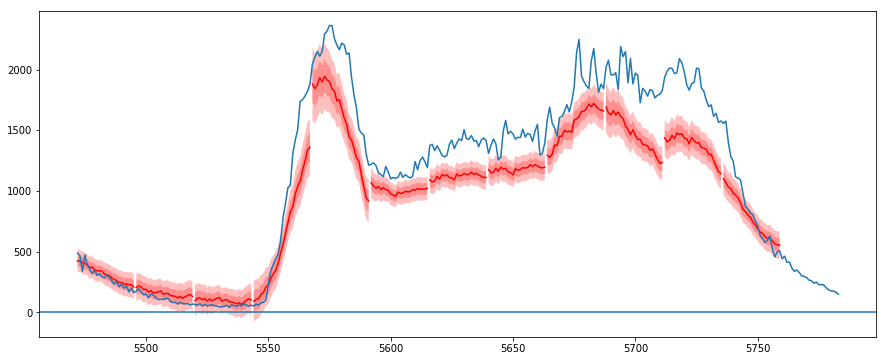

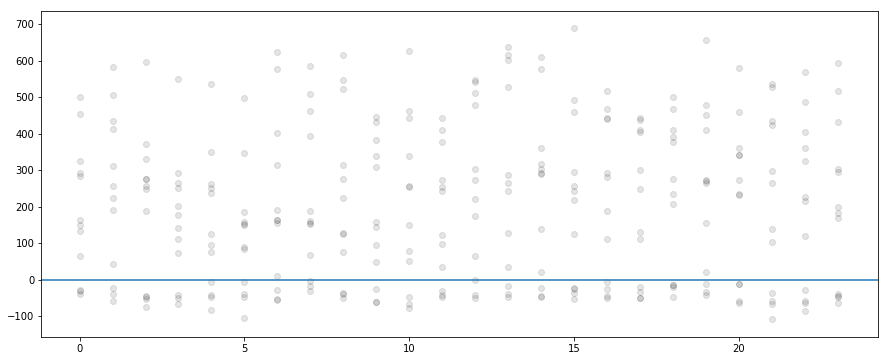

Percent Overestimating:
23.0069444444
cdf Matrix


array([[ 0.75804225,  0.68125954,  0.20276596,  0.79384613,  0.46810479,
         0.47248352,  0.26085376,  0.48624319,  0.34193442,  0.38574343,
         0.2919386 ,  0.36847689,  0.49550929,  0.4208794 ,  0.4087031 ,
         0.34636904,  0.46791302,  0.3682658 ,  0.43607301,  0.37079405,
         0.44920922,  0.2789915 ,  0.38723913,  0.33035322],
       [ 0.40127234,  0.41827069,  0.33616374,  0.34472764,  0.34861077,
         0.33071777,  0.39678163,  0.43041514,  0.34947303,  0.27684142,
         0.25350229,  0.3524551 ,  0.35067437,  0.35344458,  0.32931153,
         0.31497245,  0.32736449,  0.33008049,  0.33496792,  0.3617642 ,
         0.30623038,  0.28723581,  0.23272221,  0.30152941],
       [ 0.40327948,  0.31466306,  0.34491955,  0.33820917,  0.33970869,
         0.36958459,  0.32165357,  0.39137812,  0.31858357,  0.27838479,
         0.22771866,  0.32999818,  0.30760317,  0.32065707,  0.33201061,
         0.41772152,  0.41185085,  0.42763103,  0.43122875,  0.4552758 ,
  

In [216]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*14
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0001))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (0):
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)
func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])
predict(f=func, total_days=1,day=19,delta=24)


Epoch 1/5
21s - loss: 0.0153
Epoch 2/5
16s - loss: 0.0084
Epoch 3/5
15s - loss: 0.0073
Epoch 4/5
15s - loss: 0.0068
Epoch 5/5
16s - loss: 0.0064
Epoch 1/1
16s - loss: 0.0061
Epoch 1/1
16s - loss: 0.0058
Epoch 1/1
15s - loss: 0.0058


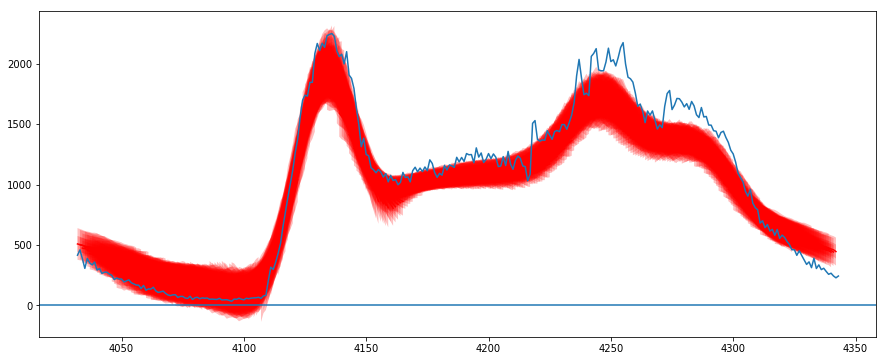

Percent Overestimating:
33.4688946759


TypeError: 'NoneType' object has no attribute '__getitem__'

In [246]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=288*21)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*13
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


b = 1
seed = 11

rate = 0.25

np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (3):
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)
func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])


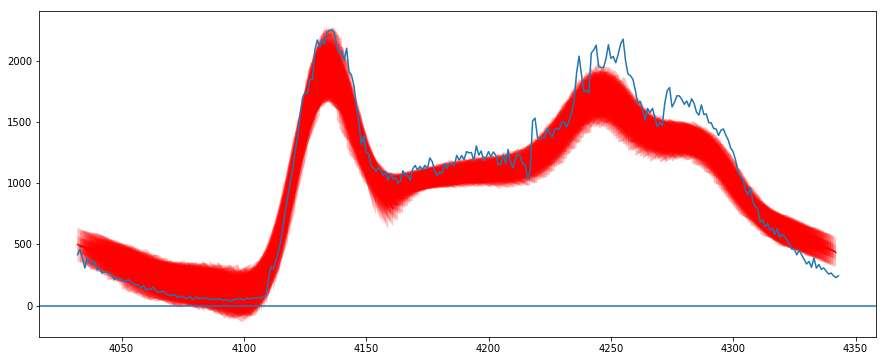

Percent Overestimating:
33.7184606481


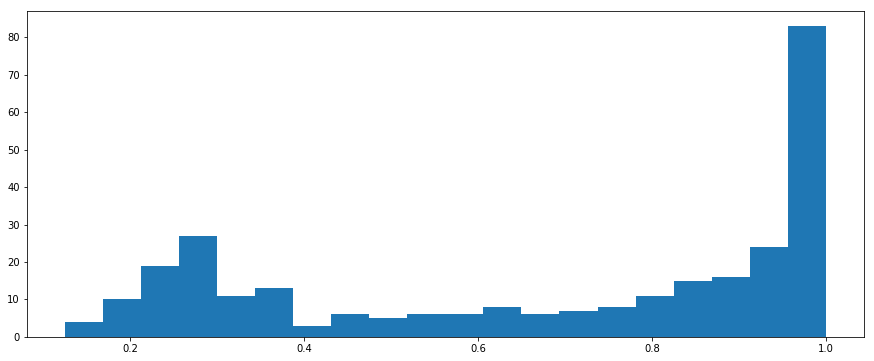

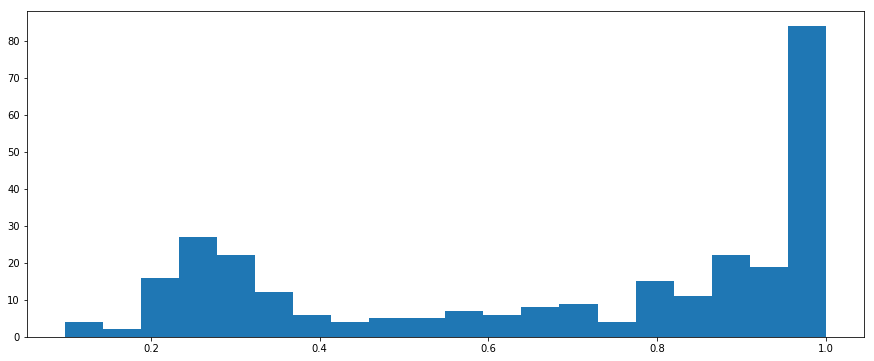

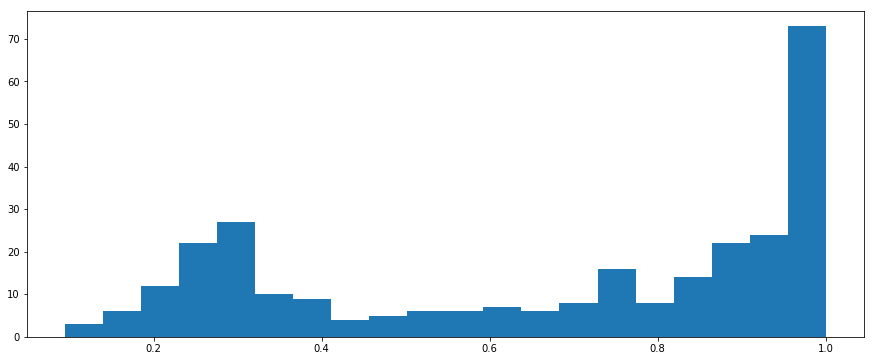

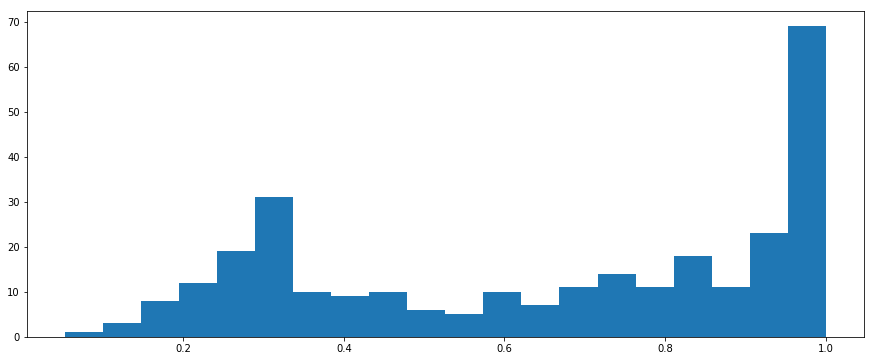

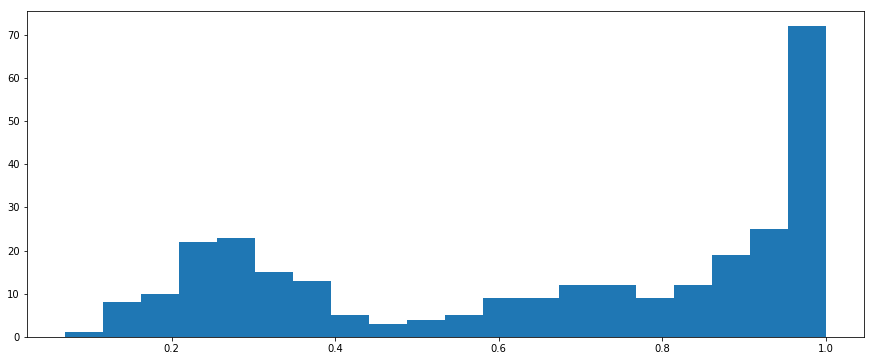

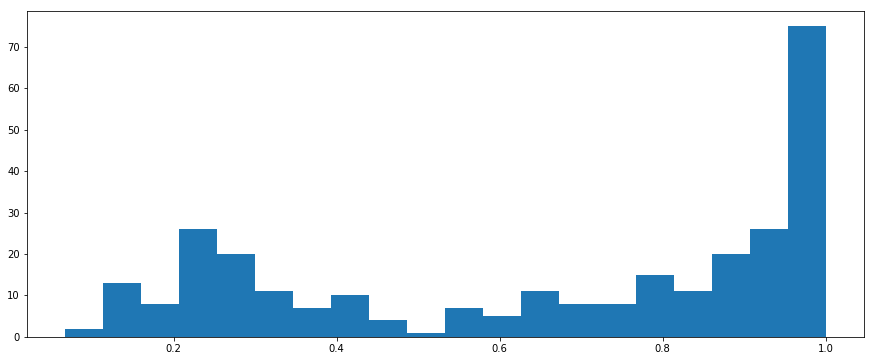

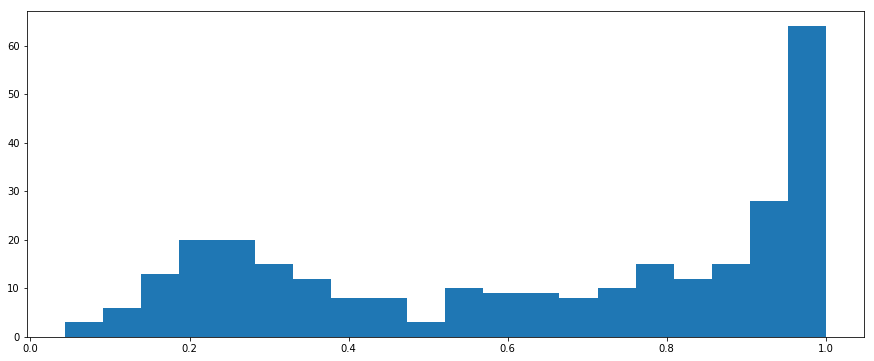

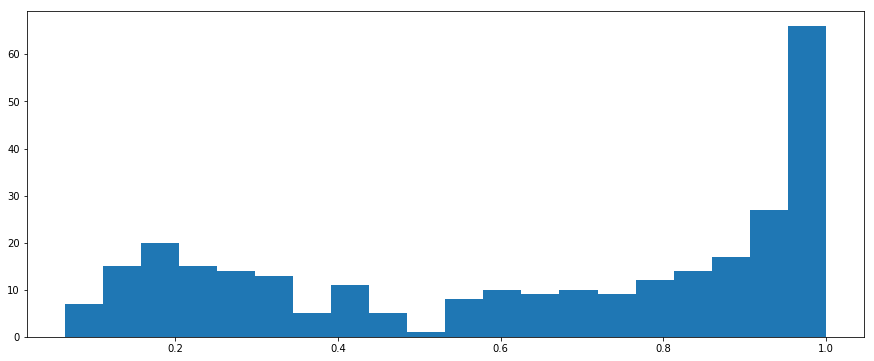

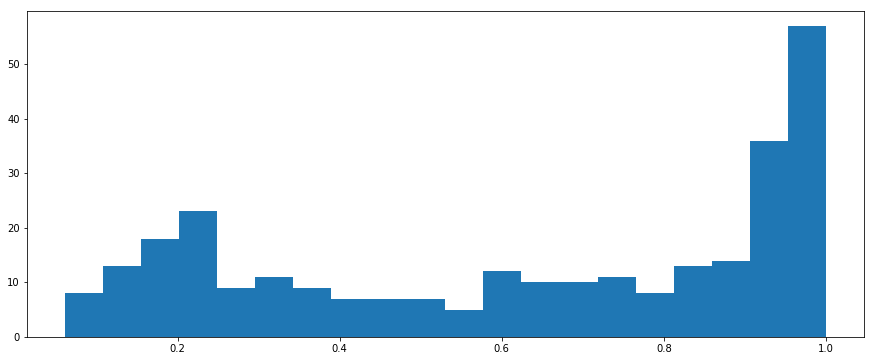

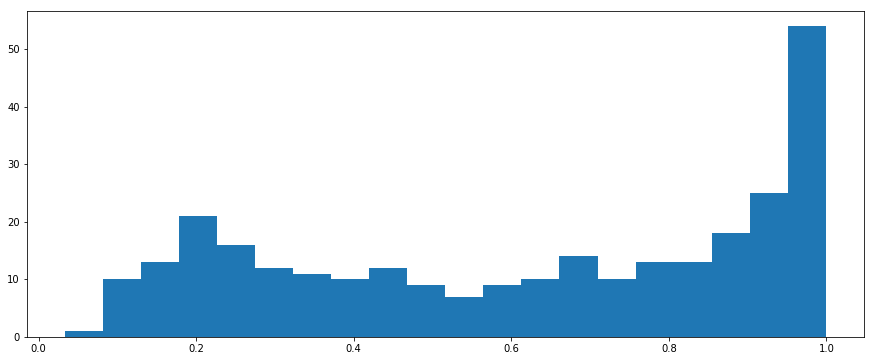

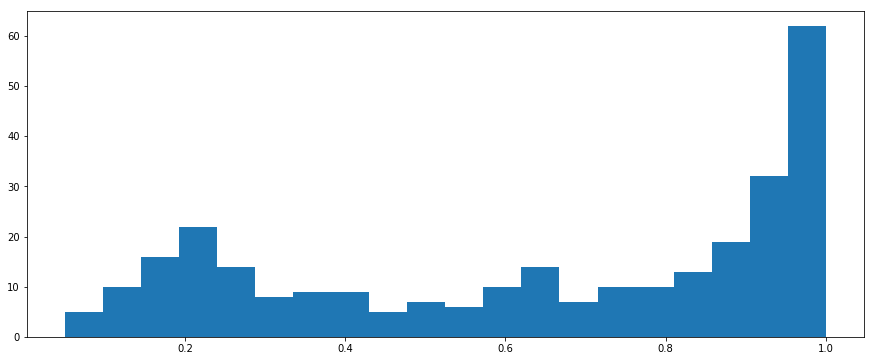

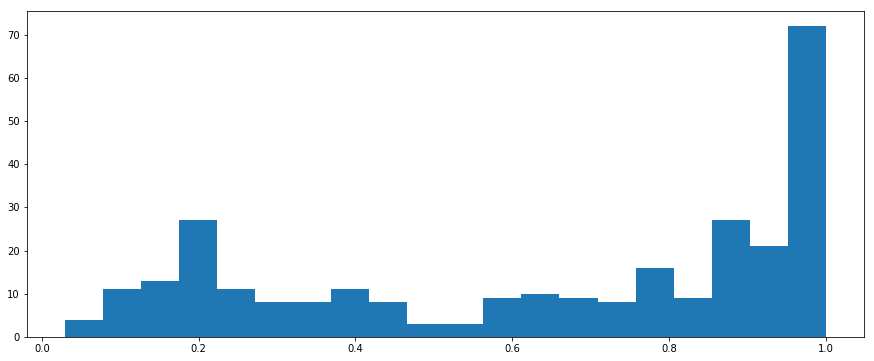

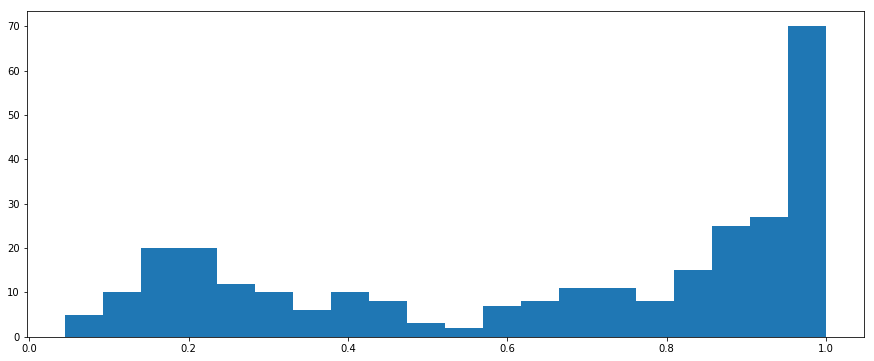

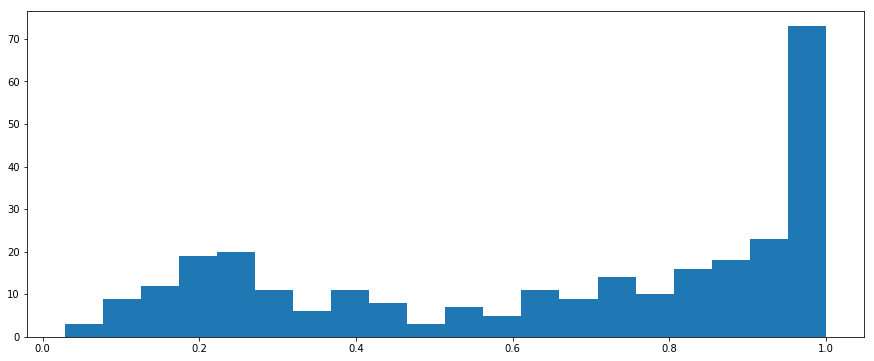

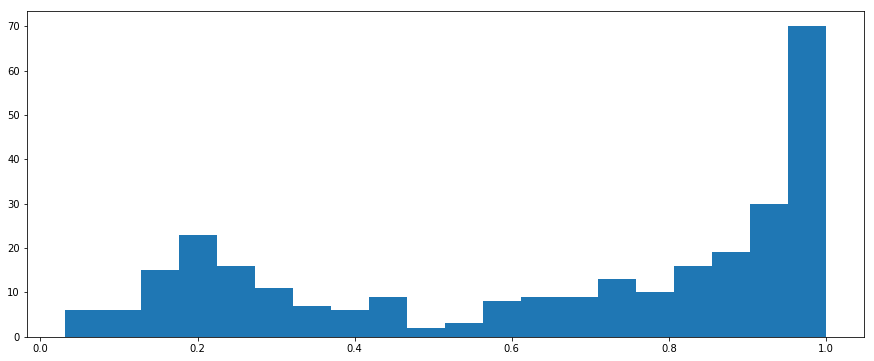

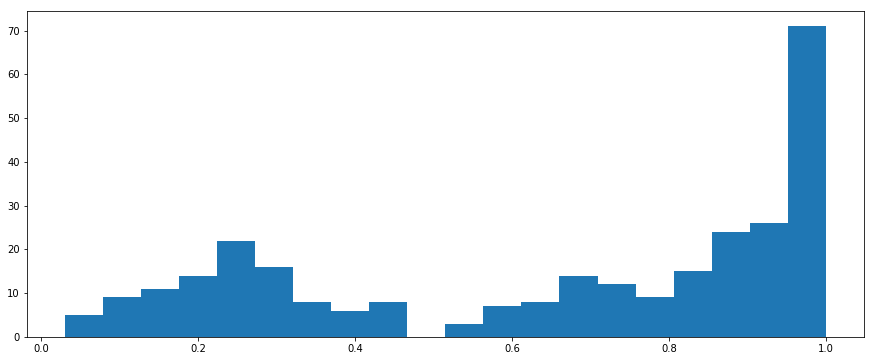

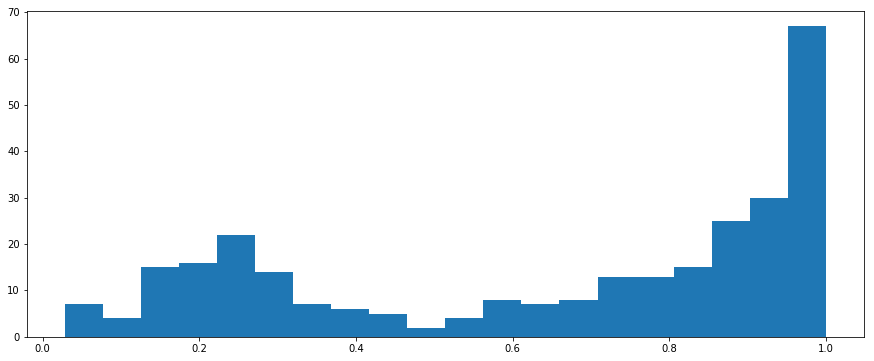

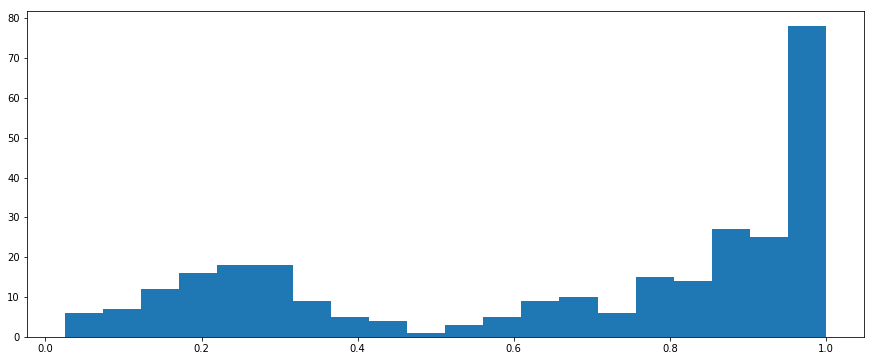

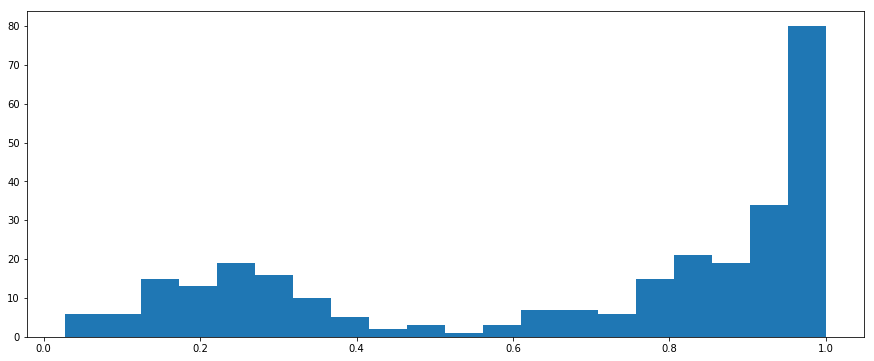

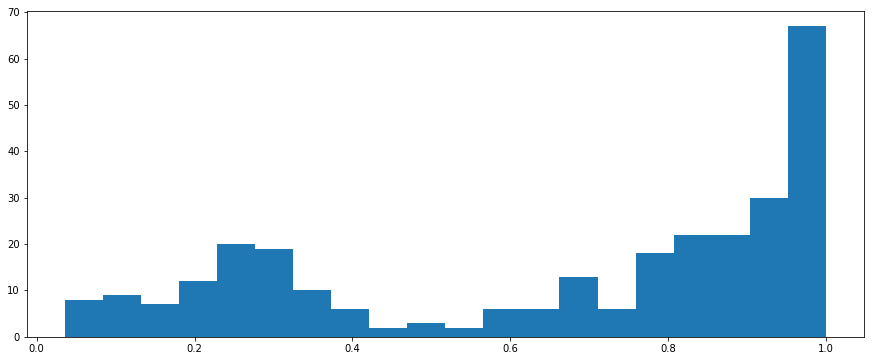

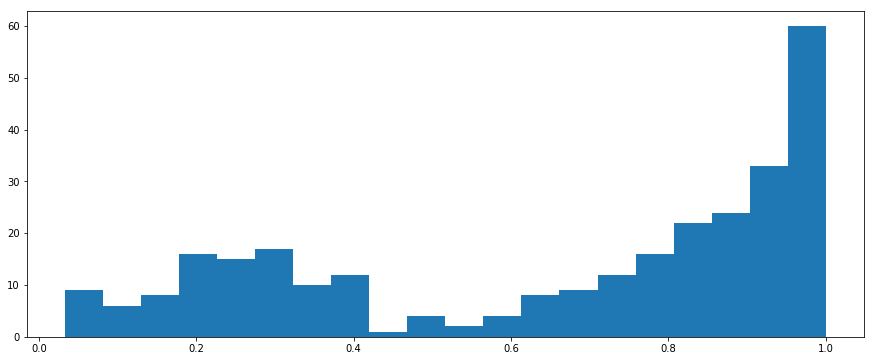

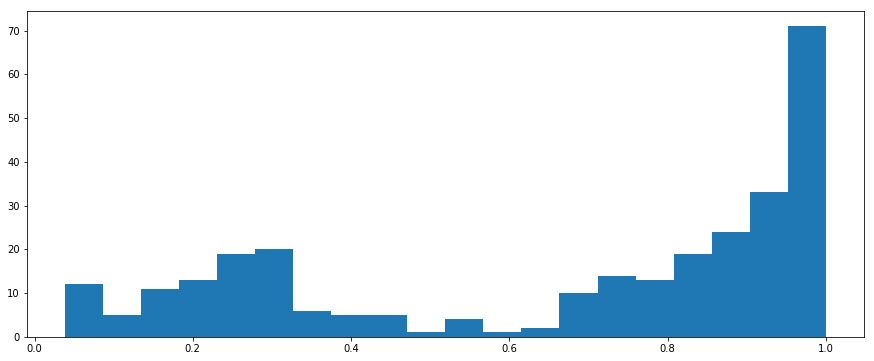

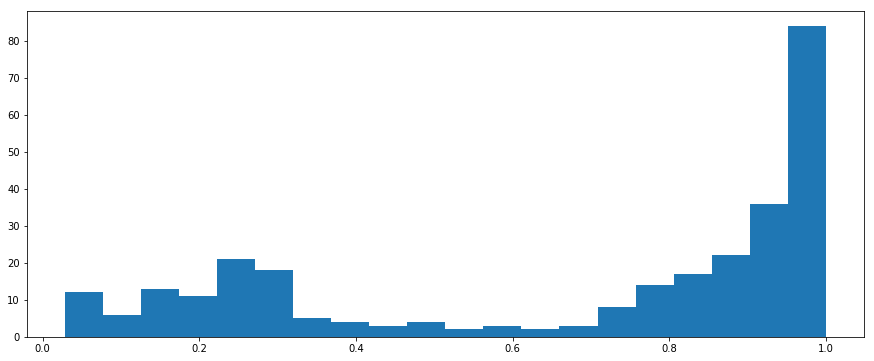

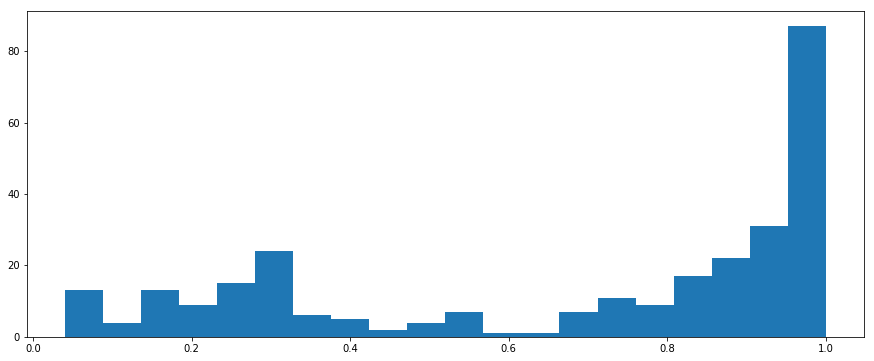

In [248]:

cdf_matrix = predict(f=func, total_days=1,day=14,delta=1)
for i in range (24):
    plt.hist(cdf_matrix[:,i],20)
    plt.show()


In [612]:
# If f is defined, this returns an array
def predictNext2Hours (model, dataset, f=None):
    dataset = np.array(dataset)
    # normalize
    #dataset = dataset.transpose()
    #dataset = dataset.reshape(-1, 1)
    dataset[0] = scaler.fit_transform(dataset[0])
    #datase"t = dataset.transpose()
    data = dataset
    data = dataset.reshape(1,2,288)
    if f is None:
        # make a prediction
        prediction = model.predict(data)
        prediction = scaler.inverse_transform(prediction)
        return prediction
    else:
        results, prediction, uncertainty = predict_with_uncertainty(f, data)
        
        # The Average Prediction
        prediction = scaler.inverse_transform(prediction)
        # The Standard Deviation At Each T Of Prediction
        standard_deviation = scaler.inverse_transform(uncertainty)
        
        return prediction, standard_deviation, results
 

In [613]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)


In [614]:
def predict (f=None, day=11, total_days=1, delta=1, show_gradual_error=False, show_graph=True):
    predictions = np.array([])
    true_vals   = np.array([])
    percent_over = np.array([])
    
    cdf_vals = np.zeros((total_days*288/delta, 24))
    
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        # Gets predictions
        if f is None:
            prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].T).reshape(look_forward)
        else:
            
            prediction, standard_deviation, results = predictNext2Hours (model, dataset_orig[point-look_back:point].T, f=f)
            
            # Gets the true original values
            true_values = dataset_orig[point:point+look_forward,0].reshape(24)
            
            # Reshapes the mean_predictions and the standard deviations into a vector of size look_forward
            prediction = prediction.reshape(look_forward)
            standard_deviation = standard_deviation.reshape(look_forward)
            
            # converts the original values to cdf values according to the distibutions at t+1, t+2, ..., t+24 (0.0-1.0)
            step_cdf_vals = norm.cdf(true_values, loc=prediction, scale=standard_deviation)
            # Adds the above values to the overall matrix of cdf
            cdf_vals[i,:] = step_cdf_vals
            
            # calculates the percent of the predictions that are overestimating
            results = results.reshape(results.shape[0], look_forward)
            results = scaler.inverse_transform(results)
            true_values = np.ones( len(results) ).reshape(len(results), 1)*true_values
            error = true_values - results
            temp_percent_over = 100.0 * (error < 0).sum() / error.size
            percent_over = np.append(percent_over, temp_percent_over)
            
            
            if(show_graph):
                # plots the uncertainty to the degree of half a standard deviation
                plt.fill_between(range(point, point+look_forward), prediction + standard_deviation/2.0, prediction - standard_deviation/2.0, facecolor='red', alpha=0.25)
                # plots the uncertainty to the degree of a full standard deviation
                plt.fill_between(range(point, point+look_forward), prediction+standard_deviation, prediction-standard_deviation, facecolor='red', alpha=0.25)
        
        
        if(show_graph):
            # plots the predictions
            plt.plot(range(point, point+look_forward), prediction, color='red', alpha=1)
        
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward,0])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    if(show_graph):
        plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
        plt.axhline(0)
        plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
    print "Percent Overestimating:"
    print np.mean(percent_over)
    return cdf_vals

In [615]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe['weekend'] = pd.to_datetime(dataframe['time_bucket']).dt.weekday < 5
dataframe = dataframe.set_index('time_bucket')

dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','weekend','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*18
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]

trainX_temp = np.ones((trainX.shape[0], trainX.shape[2], trainX.shape[1]))
for i in range(len(trainX)):
    trainX_temp[i] = trainX[i].T
trainX = trainX_temp

testX_temp = np.ones((testX.shape[0], testX.shape[2], testX.shape[1]))
for i in range(len(testX)):
    testX_temp[i] = testX[i].T
testX = testX_temp
#trainX = np.reshape(trainX.T, (trainX.shape[0], trainX.shape[2], trainX.shape[1]), order='A')
#testX = np.reshape(testX.T, (testX.shape[0], testX.shape[2], testX.shape[1]), order='A')


Epoch 1/5
30s - loss: 0.0173
Epoch 2/5
24s - loss: 0.0069
Epoch 3/5
24s - loss: 0.0055
Epoch 4/5
24s - loss: 0.0048
Epoch 5/5
24s - loss: 0.0045
0
Epoch 1/1
24s - loss: 0.0042
Epoch 1/1
24s - loss: 0.0039
Epoch 1/1
24s - loss: 0.0037
Epoch 1/1
24s - loss: 0.0038
Epoch 1/1
24s - loss: 0.0035
Epoch 1/1
24s - loss: 0.0035
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0032
10
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0032
Epoch 1/1
24s - loss: 0.0032
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0030
20
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0029
Epoch 

/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueEr

/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/rdit/development/ts-predict/venv/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


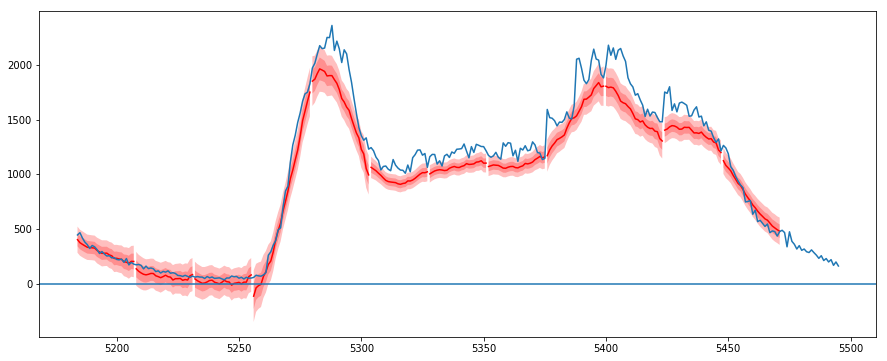

Percent Overestimating:
19.9652777778


array([[ 0.63942507,  0.77923432,  0.68761961,  0.6126091 ,  0.5816003 ,
         0.4699339 ,  0.57282159,  0.54039467,  0.52558872,  0.45102564,
         0.55579596,  0.4738577 ,  0.41135268,  0.47655283,  0.43658823,
         0.52324248,  0.46649451,  0.47394351,  0.50664667,  0.48474298,
         0.5970282 ,  0.46005499,  0.47218057,  0.43231753],
       [ 0.59385171,  0.65933037,  0.67795248,  0.632121  ,  0.7122051 ,
         0.6447372 ,  0.6433753 ,  0.62621822,  0.61049262,  0.65151371,
         0.62237458,  0.63835032,  0.58442913,  0.65730726,  0.60551731,
         0.68839789,  0.63871155,  0.5853392 ,  0.57354841,  0.59801332,
         0.60213272,  0.58705597,  0.46030848,  0.4661964 ],
       [ 0.53938203,  0.59912714,  0.61746089,  0.64910059,  0.61006316,
         0.63461282,  0.56890315,  0.58421995,  0.59875809,  0.62553391,
         0.65302469,  0.59218992,  0.51354784,  0.5992058 ,  0.60513922,
         0.72323391,  0.67003382,  0.66548893,  0.60714432,  0.65998024,
  

In [ ]:

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(2, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
#model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (40):
    if(i % 10 == 0):
        print i
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])

predict(f=func, total_days=1,day=18,delta=24)

In [ ]:

b = 1
seed = 11
rate = 0.2
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(2, look_back)))
lstm = LSTM(256, recurrent_dropout=0.3)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
#model.compile(loss='mean_squared_error', optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range (40):
    if(i % 10 == 0):
        print i
    model.fit(trainX, trainY, epochs=1, batch_size=b, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])

predict(f=func, total_days=1,day=18,delta=24)

Epoch 1/5
31s - loss: 0.0167
Epoch 2/5
24s - loss: 0.0061
Epoch 3/5
24s - loss: 0.0047
Epoch 4/5
24s - loss: 0.0043
Epoch 5/5
24s - loss: 0.0039
0
Epoch 1/1
24s - loss: 0.0037
Epoch 1/1
24s - loss: 0.0034
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0033
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0032
Epoch 1/1
24s - loss: 0.0031
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0029
10
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0030
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0029
Epoch 1/1
24s - loss: 0.0028
Epoch 1/1
24s - loss: 0.0028
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0028
Epoch 1/1
24s - loss: 0.0028
20
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1
24s - loss: 0.0027
Epoch 1/1


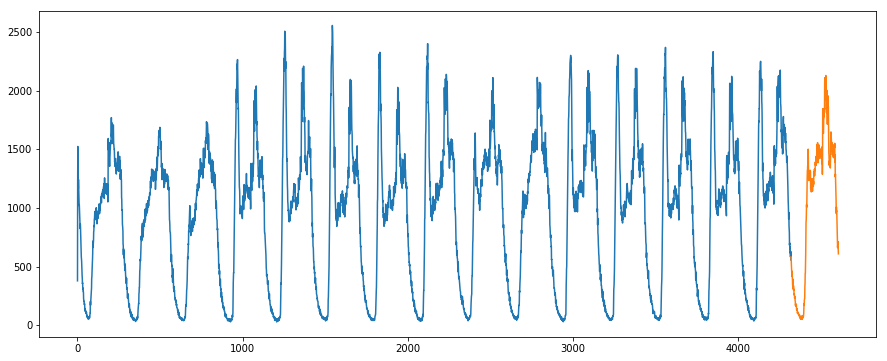

In [240]:
plt.plot(range(288*15),dataset_orig[:288*15])
plt.plot(range(288*15, 288*16), dataset_orig[288*15:288*16])

In [595]:
arr = np.array([[[ 0, 1, 2],
                 [ 3, 4, 5]],
                
                [[ 6, 7, 8],
                 [ 9,10,11]],
               
                [[12,13,14],
                 [15,16,17]]])

In [597]:
one = np.ones((arr.shape[0],arr.shape[2], arr.shape[1]))
one

array([[[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]]])

In [601]:
one

array([[[  0.,   3.],
        [  1.,   4.],
        [  2.,   5.]],

       [[  6.,   9.],
        [  7.,  10.],
        [  8.,  11.]],

       [[ 12.,  15.],
        [ 13.,  16.],
        [ 14.,  17.]]])

In [568]:
arr

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])